In [1]:
from saker import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_file = "data/addgene-plasmids-sequences.json"
work_dir = "tutorial/"

In [3]:
data = Parse_Addgene(data_file, columns=["id", "bacterial_resistance", "cloning.backbone", "pi"], maxlen=8000, flank_length=48)

In [4]:
data.info()
#data.columns
#data.head()
#data["pi"].describe()
#data["seq"]
#data["cloning.backbone"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71948 entries, 0 to 71947
Data columns (total 5 columns):
id                      71948 non-null int64
bacterial_resistance    71948 non-null object
cloning.backbone        71948 non-null object
pi                      71948 non-null object
seq                     71948 non-null object
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


In [4]:
data["seq"][0][]

'GGTCGGATTCCCGGGCTGCAGGAATTCGGCACGAGGTTGCCTGCATGAGTGTGTGCTGTGTGTCAGAGTGGATTGGAGTTGAAAAAGCTTGACTGGCGTCATTCGGGAGCTGGATGGCTTGGGACATGTGCAGCCAAGACTCTGTATGGAGTGACATAGAGTGTGCTGCTCTGGTTGGTGAGGACCAGCCTCTTTGCCCAGATCTTCCTGAACTTGACCTTTCTGAACTTGATGTGAATGACTTGGATACAGACAGCTTTCTGGGTGGATTGAAGTGGTGTAGCGACCAATCGGAAATCATATCCAACCAGTACAACAATGAGCCTGCGAACATATTTGAGAAGATAGATGAAGAGAATGAGGCAAACTTGCTAGCGGTCCTCACAGAGACACTGGACAGTCTCCCCGTGGATGAAGACGGATTGCCCTCATTTGATGCACTGACAGATGGAGCCGTGACCACTGACAACGAGGCCAGTCCTTCCTCCATGCCTGACGGCACCCCTCCCCCTCAGGAGGCAGAAGAGCCGTCTCTACTTAAGAAGCTCTTACTGGCACCAGCCAACACTCAGCTCAGCTACAATGAATGCAGCGGTCTTAGCACTCAGAACCATGCAGCAAACCACACCCACAGGATCAGAACAAACCCTGCCATTGTTAAGACCGAGAATTCATGGAGCAATAAAGCGAAGAGCATTTGTCAACAGCAAAAGCCACAAAGACGTCCCTGCTCAGAGCTTCTCAAGTATCTGACCACAAACGATGACCCTCCTCACACCAAACCCACAGAAAACAGGAACAGCAGCAGAGACAAATGTGCTTCCAAAAAGAAGTCCCATACACAACCGCAGTCGCAACATGCTCAAGCCAAACCAACAACTTTATCTCTTCCTCTGACCCCAGAGTCACCAAATGACCCCAAGGGNTCCCCATTTGAGAACNAGACTATTGAGCGAACCTTAAGTGTNNNCTCTCTGGAACTGCAGNCTACTCCTCCCA

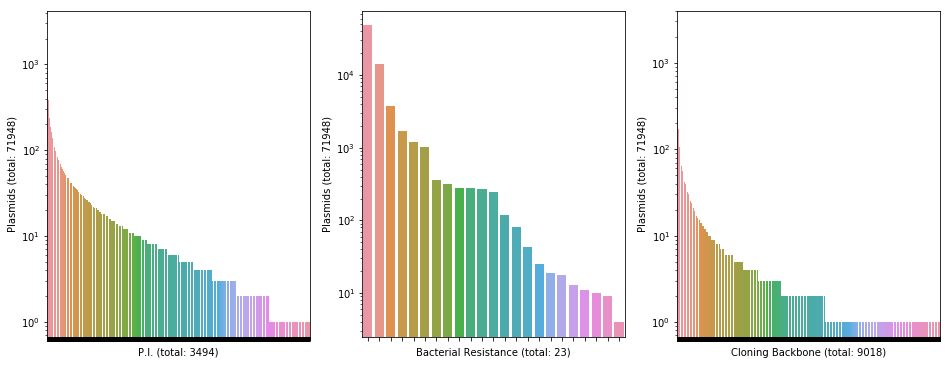

In [5]:
fig1 = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(221)
ax1 = sns.countplot(data["pi"],order=data["pi"].value_counts().index)
ax1.set(xlabel="P.I. (total: 3494)", xticklabels="",
       ylabel="Plasmids (total: 71948)", yscale="log")
ax2 = plt.subplot(222)
ax2 = sns.countplot(data["bacterial_resistance"],order=data["bacterial_resistance"].value_counts().index)
ax2.set(xlabel="Bacterial Resistance (total: 23)", xticklabels="",
       ylabel="Plasmids (total: 71948)", yscale="log")
ax3 = plt.subplot(223)
ax3 = sns.countplot(data["cloning.backbone"],order=data["cloning.backbone"].value_counts().index)
ax3.set(xlabel="Cloning Backbone (total: 9018)", xticklabels="",
       ylabel="Plasmids (total: 71948)", yscale="log")
ax4 = plt.subplot(224)
ax4 = sns.countplot(data["seq"],order=data["cloning.backbone"].value_counts().index)
ax4.set(xlabel="Cloning Backbone (total: 9018)", xticklabels="",
       ylabel="Plasmids (total: 71948)", yscale="log")
fig1.savefig(work_dir+"fig1.pdf")

In [6]:
tmp1, tmp2, tmp3 = SeparateData(data, "pi", 2000, [0.02,0.5])
train, val, test = SeparateData(tmp1, "pi", 50, [0.6,0.5])

In [7]:
encoding = [KmerEncoding, KmerEncoding, KmerEncoding, KmerEncoding]
params = [[1, 1], [3, 3], [1, 3], [2, 3]]
feature_names = ["seq_kmer_1_1", "seq_kmer_3_3", "seq_kmer_1_3", "seq_kmer_2_3"]

In [8]:
for i,enc in enumerate(encoding):
    tmp = pd.DataFrame()
    tmp[feature_names[i]] = train.apply(lambda df: enc(df["seq"], params[i][0], params[i][1]), axis=1)
    tmp["id"] = train["id"]
    tmp["pi"] = train["pi"]
    tmp.to_pickle(work_dir+feature_names[i]+".train.pkl")
    
    tmp = pd.DataFrame()
    tmp[feature_names[i]] = val.apply(lambda df: enc(df["seq"], params[i][0], params[i][1]), axis=1)
    tmp["id"] = val["id"]
    tmp["pi"] = val["pi"]
    tmp.to_pickle(work_dir+feature_names[i]+".val.pkl")
    
    tmp = pd.DataFrame()
    tmp[feature_names[i]] = test.apply(lambda df: enc(df["seq"], params[i][0], params[i][1]), axis=1)
    tmp["id"] = test["id"]
    tmp["pi"] = test["pi"]
    tmp.to_pickle(work_dir+feature_names[i]+".test.pkl")

In [5]:
#models = [Model_CNN, Model_LSTM]
models = [Model_CNN]

In [8]:
ensembledModels = []
preds_val = []
preds_test = []
for feat in feature_names:
    X_train, y_train, X_val, y_val, X_test, y_test, seqLength, seqWidth, numClasses = GetEncodedMat(work_dir, feat, "pi")
    for mod in models:
        tmpModel = mod(work_dir, feat, "pi")
        ensembledModels.append(tmpModel)
        preds_val.append(tmpModel.predict(X_val))
        preds_test.append(tmpModel.predict(X_test))

|   iter    |  target   | n_batc... |  n_epoch  | n_filters | n_kern... |  n_units  |
-------------------------------------------------------------------------------------
|  1        |  0.8636   |  15.38    |  12.26    |  104.3    |  3.398    |  40.17    |
|  2        |  1.0      |  6.821    |  37.18    |  61.37    |  14.88    |  15.77    |
|  3        |  1.0      |  20.71    |  50.55    |  112.3    |  14.26    |  4.965    |
|  4        |  1.0      |  30.54    |  93.51    |  18.77    |  10.48    |  2.799    |
|  5        |  1.0      |  9.711    |  88.64    |  122.9    |  9.902    |  36.28    |
|  6        |  0.5      |  1.0      |  100.0    |  128.0    |  1.0      |  1.0      |
{'target': 1.0, 'params': {'n_units': 15.774498123823463, 'n_filters': 61.37221963199319, 'n_kernel_size': 14.884226003633353, 'n_epoch': 37.178890924446726, 'n_batch_size': 6.8207100966128}}
_________________________________________________________________
Layer (type)                 Output Shape             

|   iter    |  target   | n_batc... |  n_epoch  | n_filters | n_kern... |  n_units  |
-------------------------------------------------------------------------------------
|  1        |  0.9091   |  15.38    |  12.26    |  104.3    |  3.398    |  40.17    |
|  2        |  1.0      |  6.821    |  37.18    |  61.37    |  14.88    |  15.77    |
|  3        |  1.0      |  20.71    |  50.55    |  112.3    |  14.26    |  4.965    |
|  4        |  1.0      |  30.54    |  93.51    |  18.77    |  10.48    |  2.799    |
|  5        |  1.0      |  9.711    |  88.64    |  122.9    |  9.902    |  36.28    |
|  6        |  0.5      |  1.0      |  100.0    |  128.0    |  1.0      |  1.0      |
{'target': 1.0, 'params': {'n_units': 15.774498123823463, 'n_filters': 61.37221963199319, 'n_kernel_size': 14.884226003633353, 'n_epoch': 37.178890924446726, 'n_batch_size': 6.8207100966128}}
_________________________________________________________________
Layer (type)                 Output Shape             

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test, seqLength, seqWidth, numClasses = GetEncodedMat(work_dir, feature_names[0], "pi")
error, best = GetBestEnsemble(len(ensembledModels), 100, 5, preds_val, y_val)
error, best

(0.0, array([1., 0., 0., 0.]))

In [10]:
test_score = 1
total = 0.0
for i in range(len(ensembledModels)):
    total += best[i]*preds_test[i]
total = np.argmax(total, axis=1)
test_score = np.sum(np.not_equal(total, np.argmax(y_test, axis=1))) / y_test.shape[0]
test_score = 1 - test_score
test_score

1.0

In [55]:
def getseq(seq, maxlen, flank_length):
    if len(seq) > maxlen:
        seq = seq[:maxlen]
    else:
        seq += "N"*(maxlen-len(seq)) 
    revcomp = seq.translate(str.maketrans("ACGTN", "TGCAN"))[::-1]
    return seq + "N"*flank_length + revcomp

In [7]:
myData = pd.DataFrame()
seq = 'GCAAAAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTACTTCGCGTTATGCAGGCTTTACTAGTAGCGGCCGCTGCAGTCCGTTTCTTTAAAACC'
myData["seq"] = [getseq(seq, 8000, 48)]
for i,enc in enumerate(encoding):
    myData[feature_names[i]] = myData.apply(lambda df: enc(df["seq"], params[i][0], params[i][1]), axis=1)

NameError: name 'getseq' is not defined

In [6]:
myData

NameError: name 'myData' is not defined

In [5]:
myData.seq_kmer_1_1

NameError: name 'myData' is not defined

In [99]:
total = 0.0
for i in range(len(ensembledModels)):
    X_myData = []
    for j in myData[feature_names[i]]:
        X_myData.append(j)
    X_myData = np.array(X_myData)
    pred = ensembledModels[i].predict(X_myData)
    total += best[i]*pred
total

array([[0.9984629 , 0.00153709]], dtype=float32)

In [100]:
def MakeMutations(seq, mut_length):
    mut_seq = []
    for i in range(len(seq)+1-mut_length):
        mut_seq.append(seq[:i] + 'N'*mut_length + seq[i+mut_length:])
    return mut_seq

In [112]:
myData_mut = pd.DataFrame()
myData_mut["seqs"] = MakeMutations(seq, 1)
myData_mut["seq"] = myData_mut.apply(lambda df: getseq(df["seqs"], 8000, 48), axis=1)
myData_mut

,seqs,seq
0,NCAAAAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...,NCAAAAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...
1,GNAAAAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...,GNAAAAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...
2,GCNAAAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...,GCNAAAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...
3,GCANAAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...,GCANAAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...
4,GCAANAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...,GCAANAAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...
5,GCAAANAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...,GCAAANAAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...
6,GCAAAANAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...,GCAAAANAACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...
7,GCAAAAANACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...,GCAAAAANACGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...
8,GCAAAAAANCGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...,GCAAAAAANCGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...
9,GCAAAAAAANGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...,GCAAAAAAANGGGCAAGGTGTCACCACCCTGCCCTTGAAAAGATTA...


In [113]:
for i,enc in enumerate(encoding):
    myData_mut[feature_names[i]] = myData_mut.apply(lambda df: enc(df["seq"], params[i][0], params[i][1]), axis=1)

In [114]:
total_mut = 0.0
for i in range(len(ensembledModels)):
    X_myData_mut = []
    for j in myData_mut[feature_names[i]]:
        X_myData_mut.append(j)
    X_myData_mut = np.array(X_myData_mut)
    pred = ensembledModels[i].predict(X_myData_mut)
    total_mut += best[i]*pred
total_mut

array([[9.9869734e-01, 1.3027311e-03],
       [9.9791569e-01, 2.0842617e-03],
       [9.9826729e-01, 1.7326962e-03],
       [9.9799854e-01, 2.0014553e-03],
       [9.9868160e-01, 1.3183909e-03],
       [9.9889565e-01, 1.1043367e-03],
       [9.9827194e-01, 1.7280326e-03],
       [9.9869019e-01, 1.3098238e-03],
       [9.9782407e-01, 2.1759078e-03],
       [9.9750453e-01, 2.4954812e-03],
       [9.9827015e-01, 1.7297986e-03],
       [9.9840683e-01, 1.5931429e-03],
       [9.9839443e-01, 1.6055983e-03],
       [9.9736625e-01, 2.6338277e-03],
       [9.9871540e-01, 1.2845687e-03],
       [9.9831736e-01, 1.6826782e-03],
       [9.9818534e-01, 1.8146434e-03],
       [9.9832743e-01, 1.6725686e-03],
       [9.9834716e-01, 1.6528851e-03],
       [9.9933892e-01, 6.6106708e-04],
       [9.9656492e-01, 3.4351235e-03],
       [9.9860209e-01, 1.3979132e-03],
       [9.9906284e-01, 9.3722716e-04],
       [9.9886608e-01, 1.1339480e-03],
       [9.9816787e-01, 1.8321397e-03],
       [9.9847621e-01, 1.

In [109]:
total_mut.transpose()[0]

array([0.99977654, 0.99923897, 0.99870646, 0.9985361 , 0.99916446,
       0.9993193 , 0.99949706, 0.9992211 , 0.99827206, 0.9986712 ,
       0.9993716 , 0.99863225, 0.9991574 , 0.9983954 , 0.99871624,
       0.9980792 , 0.99741566, 0.9983304 , 0.9972771 , 0.9980107 ,
       0.99932563, 0.999361  , 0.99949443, 0.9999312 ], dtype=float32)

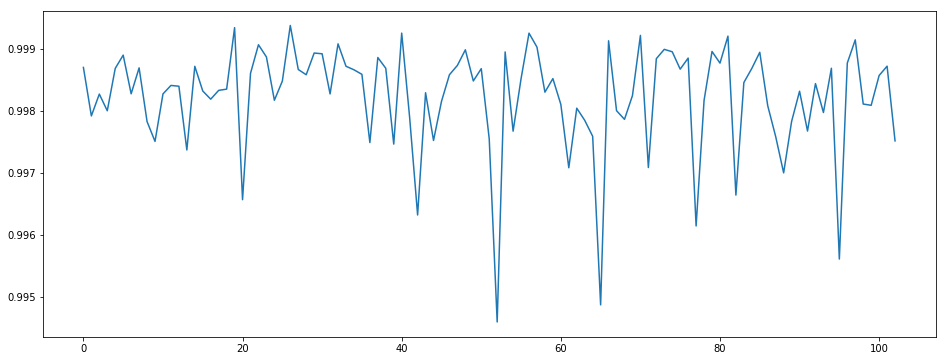

In [116]:
fig2 = plt.figure(figsize=(16, 6))
ax1 = sns.lineplot(data=total_mut.transpose()[0])
#ax1.set(xlabel="P.I. (total: 3494)", xticklabels="",
       #ylabel="Plasmids (total: 71948)", yscale="log")

fig2.savefig(work_dir+"fig2.pdf")

In [128]:
np.log(-2.39549521e-02)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


nan

In [132]:
np.transpose(100000**(ensembledModels[0].get_layer("conv1d_1").get_weights()[0][0]))

array([[0.7589711 , 0.4286198 , 3.0841786 , 0.58154187, 0.97894764],
       [0.50214905, 1.75664331, 0.73340576, 1.55889282, 2.2227555 ],
       [1.57780161, 0.83497634, 1.21642264, 1.96814028, 0.4365716 ],
       [1.15036145, 1.40859052, 0.34515262, 1.57075545, 2.30413146],
       [0.41997377, 1.38800478, 0.73538966, 0.39523278, 0.84436997],
       [1.22529732, 0.7010728 , 1.82370431, 0.47381028, 1.2324594 ],
       [0.47253919, 0.63250528, 0.86558832, 0.5788142 , 1.4637065 ],
       [1.36209069, 1.83132545, 0.6021505 , 0.50987723, 0.72466359],
       [0.86891448, 1.7759153 , 1.64977057, 0.77067516, 1.84397401],
       [0.86384666, 0.33800392, 0.89410843, 1.58091257, 1.41181933],
       [0.71531167, 0.38157492, 0.59107401, 1.13283667, 1.83128586],
       [0.41014753, 0.34821993, 0.60009502, 0.58925356, 0.69639253],
       [0.66567605, 0.6610164 , 1.35234204, 0.83840708, 0.9914236 ],
       [2.4300918 , 1.28029152, 1.57277604, 1.11629147, 0.92267323],
       [1.2703346 , 1.63744645, 1.

In [124]:
ensembledModels[0].get_layer("conv1d_1").get_weights()[0][0]

array([[-2.39549521e-02, -5.98334707e-02,  3.96104790e-02,
         1.21668642e-02, -7.53555670e-02,  1.76482964e-02,
        -6.51124343e-02,  2.68412046e-02, -1.22045930e-02,
        -1.27126686e-02, -2.91009378e-02, -7.74119794e-02,
        -3.53474133e-02,  7.71245360e-02,  2.07836255e-02,
         8.14908594e-02, -1.01994118e-02,  4.71907444e-02,
         4.99357507e-02, -2.50214506e-02,  2.62655737e-03,
         3.13565433e-02,  7.72277638e-02, -2.00890843e-02,
        -8.03072285e-03, -3.71160693e-02,  9.37161501e-03,
         7.64768869e-02,  1.23363100e-02, -2.90180668e-02,
         6.89063296e-02, -1.88590866e-02,  3.43237631e-02,
         6.65775910e-02, -5.47404885e-02,  5.82981743e-02,
         7.44524300e-02, -6.64130002e-02,  8.26063007e-02,
        -3.07665225e-02,  4.79218587e-02, -4.63941172e-02,
        -3.57108600e-02,  1.41938040e-02, -7.48545825e-02,
         4.16556783e-02,  6.68917447e-02, -5.80668226e-02,
         3.67554165e-02,  1.88092571e-02,  6.84471205e-0